##**Awtad Project**




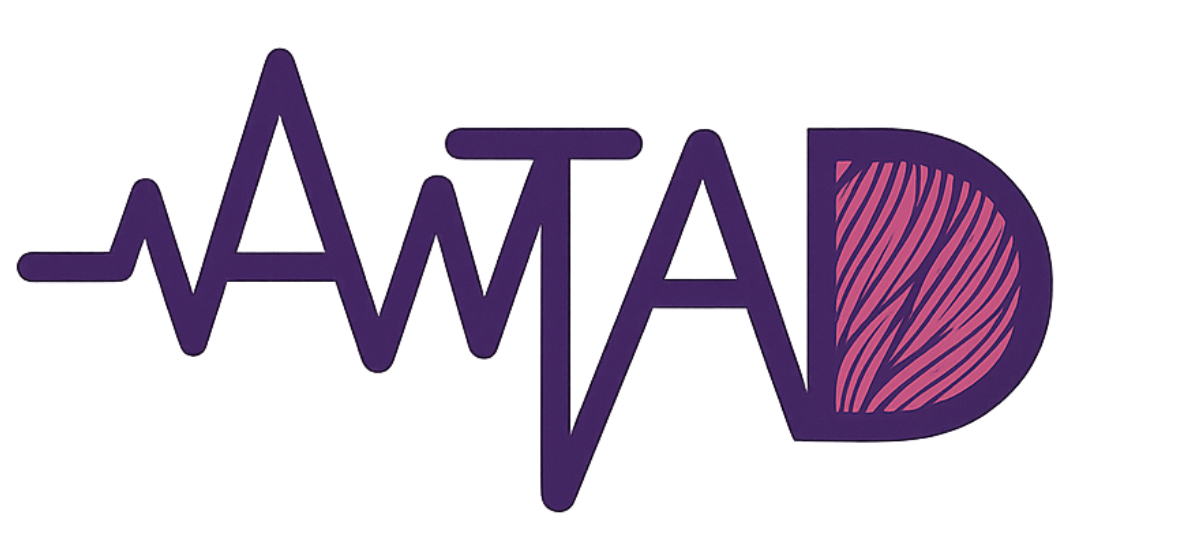

##IT-496 Graduation Project

This notebook presents the development of Awtad, a system designed to detect muscle imbalance using surface EMG (sEMG) signals collected from the Delsys Trigno sensors.
It demonstrates each stage of the pipeline from data acquisition and preprocessing to feature extraction, imbalance analysis, and result visualization.

##Import Libraries & Setup

This section initializes the working environment, imports the required Python libraries, and configures essential settings for reproducibility and organization.

All packages related to signal processing, data manipulation, visualization, and model training are imported here to ensure a clean and consistent runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy.signal import resample_poly
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from scipy.signal import butter, filtfilt
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

##Dataset Overview

For model training and evaluation, this project uses the Georgia Tech Lower-Limb sEMG Dataset, which provides surface electromyography (sEMG) recordings from multiple lower-limb muscles during various controlled movements.
The dataset includes bilateral muscle signals (left and right sides), making it suitable for developing and testing the muscle imbalance detection model in the Otad system.

Each recording contains:

Signal type: Surface EMG (sEMG)

Sampling rate: 2000 Hz

Muscles recorded: Multiple lower-limb muscles such as Rectus Femoris, Biceps Femoris, and Tibialis Anterior on both sides

Subjects: Healthy participants performing repeated lower-limb movements

These signals were used for data preprocessing, feature extraction (RMS, symmetry index), and training the imbalance classification model.

The trained model will later be validated and refined using real EMG data collected from the Delsys Trigno Avanti sensors during testing sessions in the Otad system.

###Raw Data Loading
This code mounts Google Drive to Colab and loads all participant folders (p1, p2, …).
Each participant folder contains raw EMG data files for two activities: squat and jump.
The code reads each CSV file and stores it in a Python dictionary called data, where each participant has their own sub-dictionary with the two activities.

In [ ]:

base_path = '/content/drive/MyDrive/Awtad_Data'

participants = sorted([f for f in os.listdir(base_path) if f.startswith('p')])

data = {}

for p in participants:
    folder = os.path.join(base_path, p)

    squat_path = os.path.join(folder, 'Raw_EMGs_squat.csv')
    jump_path = os.path.join(folder, 'Raw_EMGs_jump1.csv')


    participant_data = {}

    if os.path.exists(squat_path):
        participant_data['squat'] = pd.read_csv(squat_path)
        print(f"Loaded squat for {p}")
    else:
        print(f"Squat file missing for {p}")

    if os.path.exists(jump_path):
        participant_data['jump'] = pd.read_csv(jump_path)
        print(f"Loaded jump for {p}")
    else:
        print(f"Jump file missing for {p}")


    data[p] = participant_data

print("\nAll participant data loaded successfully!")
print("Total participants:", len(data))



Loaded squat for p1
Loaded jump for p1
Loaded squat for p10
Loaded jump for p10
Loaded squat for p11
Loaded jump for p11
Loaded squat for p12
Loaded jump for p12
Loaded squat for p2
Loaded jump for p2
Loaded squat for p3
Loaded jump for p3
Loaded squat for p4
Loaded jump for p4
Loaded squat for p5
Loaded jump for p5
Loaded squat for p6
Loaded jump for p6
Loaded squat for p7
Loaded jump for p7
Loaded squat for p8
Loaded jump for p8
Loaded squat for p9
Loaded jump for p9

All participant data loaded successfully!
Total participants: 12


This code displays the first few rows of the first participant’s first activity (e.g., p1 – squat) to visually confirm that the data was loaded correctly and that all muscle channels are present.

In [ ]:
if data:
    first_p = list(data.keys())[0]
    first_activity = list(data[first_p].keys())[0]


    print(f"📂 Participant: {first_p} | Activity: {first_activity}")
    display(data[first_p][first_activity].head())
else:
    print("⚠️ No participant data loaded. Please check the data loading step (Cell u4mmMnjfCQiU).")

📂 Participant: p1 | Activity: squat


,time,LTA,RTA,LRF,RRF,LBF,RBF,LGMED,RGMED,LMGAS,RMGAS,LVL,RVL,LGRAC,RGRAC,LGMAX,RGMAX
0,0.0000,-0.000014,-0.000015,-0.000017,-0.000024,-0.000025,0.000013,-0.000008,-0.000009,0.000005,0.000043,-0.000061,-0.000041,-0.000031,-0.000009,0.000015,-0.000032
1,0.0005,-0.000015,-0.000016,-0.000021,-0.000024,-0.000026,0.000012,-0.000007,-0.000010,0.000004,0.000044,-0.000080,-0.000039,-0.000032,-0.000011,0.000016,-0.000034
2,0.0010,-0.000016,-0.000016,-0.000025,-0.000024,-0.000027,0.000011,-0.000006,-0.000011,0.000002,0.000042,-0.000102,-0.000038,-0.000034,-0.000012,0.000017,-0.000036
3,0.0015,-0.000016,-0.000017,-0.000031,-0.000025,-0.000028,0.000011,-0.000006,-0.000011,0.000002,0.000042,-0.000117,-0.000039,-0.000034,-0.000013,0.000019,-0.000038
4,0.0020,-0.000016,-0.000016,-0.000041,-0.000027,-0.000027,0.000012,-0.000006,-0.000011,0.000004,0.000043,-0.000119,-0.000040,-0.000034,-0.000014,0.000020,-0.000038


In [ ]:
for participant, activities in data.items():
    print(f"Participant: {participant}")
    for activity, df in activities.items():
        print(f"  {activity}: {df.shape}")

Participant: p1
  squat: (121950, 17)
  jump: (113680, 17)
Participant: p10
  squat: (83180, 17)
  jump: (122750, 17)
Participant: p11
  squat: (72660, 17)
  jump: (116800, 17)
Participant: p12
  squat: (106720, 17)
  jump: (127820, 17)
Participant: p2
  squat: (77790, 17)
  jump: (28430, 17)
Participant: p3
  squat: (75730, 17)
  jump: (136930, 17)
Participant: p4
  squat: (52960, 17)
  jump: (91070, 17)
Participant: p5
  squat: (145140, 17)
  jump: (114020, 17)
Participant: p6
  squat: (95020, 17)
  jump: (86340, 17)
Participant: p7
  squat: (105320, 17)
  jump: (108900, 17)
Participant: p8
  squat: (79430, 17)
  jump: (102430, 17)
Participant: p9
  squat: (82040, 17)
  jump: (110640, 17)


###Muscle Selection

This code filters each participant’s data to include only the target muscle channels.
For squat, it keeps LVL and RVL, and for jump, it keeps LMGAS and RMGAS.
The function select_muscle_channels searches for those specific names in the column list and returns only the matching ones

In [ ]:
# Define target muscles
TARGET_MUSCLES = {
    "squat": ["LVL", "RVL"],
    "jump": ["LMGAS", "RMGAS"]
    }

# Function to select columns related to the target muscles
def select_muscle_channels(df, target_list):
    selected = []
    for col in df.columns:
        for name in target_list:
            if name.lower() in col.lower():
                selected.append(col)
    # Remove duplicates while keeping the original order
    selected = list(dict.fromkeys(selected))
    return selected


# Dictionary to store selected columns for each participant
selected_data = {}

# Loop through each participant and each activity
for p, files in data.items():
    selected_data[p] = {}
    for activity, df in files.items():
        # Target muscles based on activity type
        targets = TARGET_MUSCLES.get(activity, [])
        cols = select_muscle_channels(df, targets)

        # Save columns if found
        if cols:
            selected_data[p][activity] = df[cols].copy()
            print(f"{p} - {activity}: Found {len(cols)} channels {cols}")
        else:
            print(f"{p} - {activity}: No target muscles found")

print("\nTarget muscles successfully selected and ready for Preprocessing")


p1 - squat: Found 2 channels ['LVL', 'RVL']
p1 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p10 - squat: Found 2 channels ['LVL', 'RVL']
p10 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p11 - squat: Found 2 channels ['LVL', 'RVL']
p11 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p12 - squat: Found 2 channels ['LVL', 'RVL']
p12 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p2 - squat: Found 2 channels ['LVL', 'RVL']
p2 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p3 - squat: Found 2 channels ['LVL', 'RVL']
p3 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p4 - squat: Found 2 channels ['LVL', 'RVL']
p4 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p5 - squat: Found 2 channels ['LVL', 'RVL']
p5 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p6 - squat: Found 2 channels ['LVL', 'RVL']
p6 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p7 - squat: Found 2 channels ['LVL', 'RVL']
p7 - jump: Found 2 channels ['LMGAS', 'RMGAS']
p8 - squat: Found 2 channels ['LVL', 'RVL']
p8 - jump: Found 2 channels ['LMGAS', 'R

#Signal *Preprocessing*




The signal preprocessing stage converts all raw recordings into a uniform, high-quality format suitable for feature extraction.

##Band-Pass Filter

This code applies a band-pass filter (20–450 Hz) to all EMG signals for all participants and exercises.
The filter removes:

Low-frequency noise such as movement artifacts below 20 Hz,

High-frequency noise such as electrical interference above 450 Hz.


To clean the raw EMG signal by keeping only the valid muscle-activity range (20–450 Hz) and removing unwanted noise.

In [ ]:
# Step 1 of Preprocessing: Band-Pass Filter (20–450 Hz)

# Filter settings
fs = 2000          # Sampling frequency (Hz)
lowcut = 20        # Lower cutoff frequency
highcut = 450      # Upper cutoff frequency
order = 4          # Filter order

# Dictionary to store results
bandpassed_data = {}

# Apply filtering to all participants, activities, and muscles
for p, activities in selected_data.items():
    bandpassed_data[p] = {}
    for activity, df in activities.items():
        filtered_df = df.copy()
        for col in df.columns:
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = butter(order, [low, high], btype='band')
            filtered_signal = filtfilt(b, a, df[col].values)
            filtered_df[col] = filtered_signal

        bandpassed_data[p][activity] = filtered_df
        print(f"Band-pass applied for {p} - {activity}: {list(df.columns)}")

print("\nBand-Pass Filtering step successfully applied to all participants")

Band-pass applied for p1 - squat: ['LVL', 'RVL']
Band-pass applied for p1 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p10 - squat: ['LVL', 'RVL']
Band-pass applied for p10 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p11 - squat: ['LVL', 'RVL']
Band-pass applied for p11 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p12 - squat: ['LVL', 'RVL']
Band-pass applied for p12 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p2 - squat: ['LVL', 'RVL']
Band-pass applied for p2 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p3 - squat: ['LVL', 'RVL']
Band-pass applied for p3 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p4 - squat: ['LVL', 'RVL']
Band-pass applied for p4 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p5 - squat: ['LVL', 'RVL']
Band-pass applied for p5 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p6 - squat: ['LVL', 'RVL']
Band-pass applied for p6 - jump: ['LMGAS', 'RMGAS']
Band-pass applied for p7 - squat: ['LVL', 'RVL']
Band-pass applied for p7 - jump: ['L

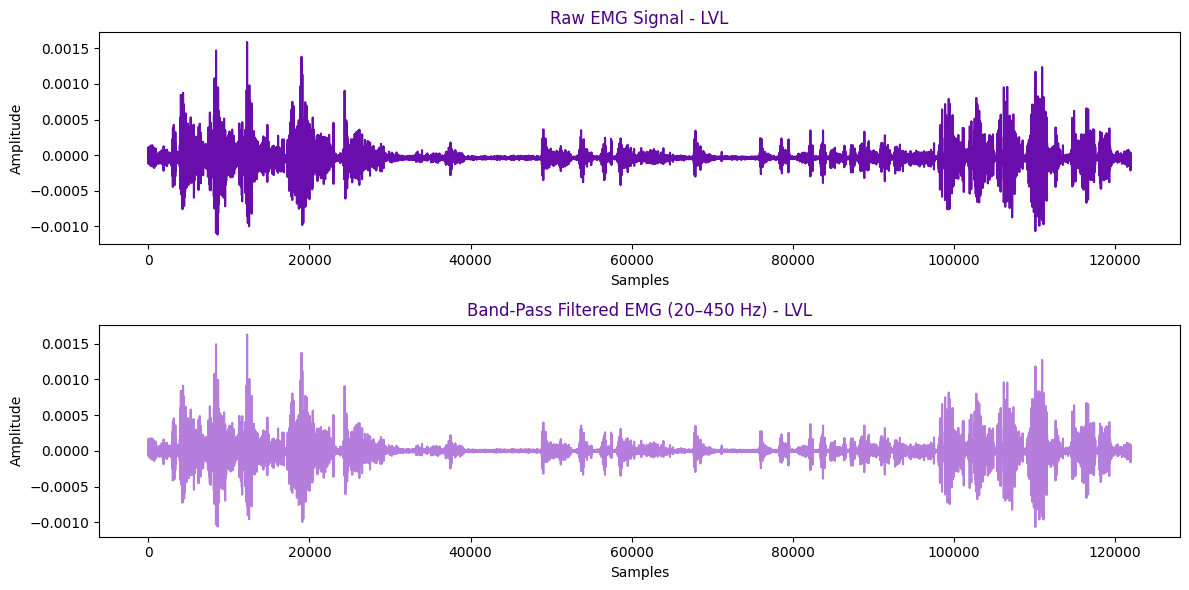

In [ ]:
# ------------------------------------------------
# Similar to what was done for rectification: selecting participant/activity/muscle
# ------------------------------------------------
p = list(selected_data.keys())[0]       # First participant
activity = list(selected_data[p].keys())[0]   # First activity
muscle = selected_data[p][activity].columns[0]  # First muscle

# ------------------------------------------------
# Raw signal (before filtering)
# ------------------------------------------------
raw_signal = selected_data[p][activity][muscle].values

# ------------------------------------------------
# Filtered signal (after band-pass)
# Taken from the 'bandpassed_data' that was prepared
# ------------------------------------------------
filtered_signal = bandpassed_data[p][activity][muscle].values

# ------------------------------------------------
# Plotting comparison
# ------------------------------------------------
plt.figure(figsize=(12, 6))

# ---- Raw EMG ----
plt.subplot(2, 1, 1)
plt.plot(raw_signal, color='#6a0dad')   # Dark purple
plt.title(f"Raw EMG Signal - {muscle}", fontsize=12, color='#4b0082')
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)

# ---- Band-Pass EMG ----
plt.subplot(2, 1, 2)
plt.plot(filtered_signal, color='#b57edc')   # Light purple
plt.title(f"Band-Pass Filtered EMG (20–450 Hz) - {muscle}", fontsize=12, color='#4b0082')
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Amplitude", fontsize=10)

plt.tight_layout()
plt.show()

##Rectification






Convert all negative EMG signal values into positive ones using absolute value — so the signal represents muscle activation intensity only, not direction

In [ ]:

# Step 2 of Preprocessing: Rectification
rectified_data = {}

for p, activities in bandpassed_data.items():
    rectified_data[p] = {}
    for activity, df in activities.items():
        rectified_df = df.copy()
        for col in df.columns:
            rectified_df[col] = np.abs(df[col].values)  # Absolute value for each sample
        rectified_data[p][activity] = rectified_df
        print(f"Rectified EMG for {p} - {activity}: {list(df.columns)}")

print("\nRectification step successfully applied to all participants")

Rectified EMG for p1 - squat: ['LVL', 'RVL']
Rectified EMG for p1 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p10 - squat: ['LVL', 'RVL']
Rectified EMG for p10 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p11 - squat: ['LVL', 'RVL']
Rectified EMG for p11 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p12 - squat: ['LVL', 'RVL']
Rectified EMG for p12 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p2 - squat: ['LVL', 'RVL']
Rectified EMG for p2 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p3 - squat: ['LVL', 'RVL']
Rectified EMG for p3 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p4 - squat: ['LVL', 'RVL']
Rectified EMG for p4 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p5 - squat: ['LVL', 'RVL']
Rectified EMG for p5 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p6 - squat: ['LVL', 'RVL']
Rectified EMG for p6 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p7 - squat: ['LVL', 'RVL']
Rectified EMG for p7 - jump: ['LMGAS', 'RMGAS']
Rectified EMG for p8 - squat: ['LVL', 'RVL']
Rectified EMG for p

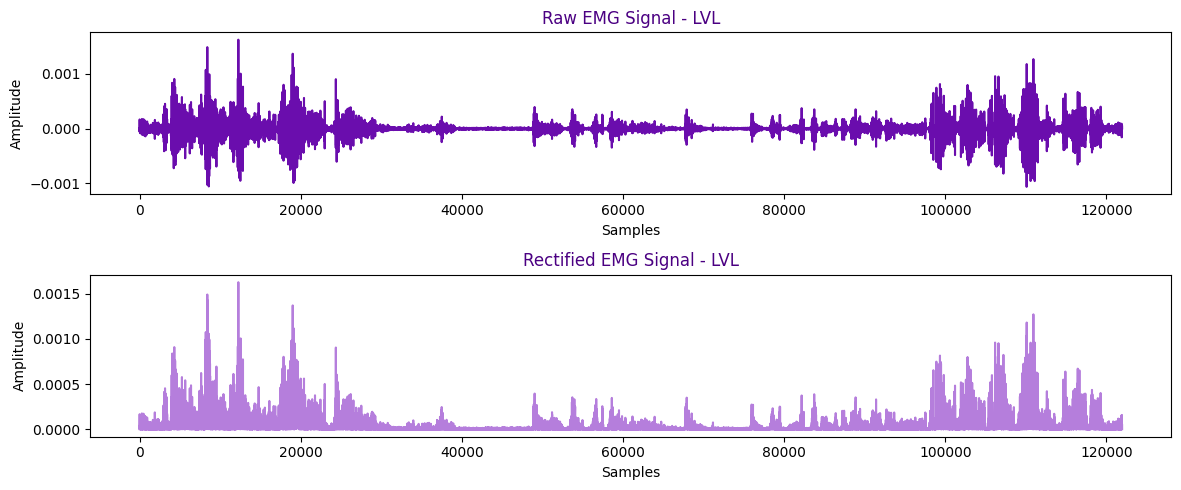

In [ ]:

# Select a sample participant and activity
p = list(bandpassed_data.keys())[0]
activity = list(bandpassed_data[p].keys())[0]

# Choose a specific muscle channel
muscle = bandpassed_data[p][activity].columns[0]

# Raw signal (before rectification)
raw_signal = bandpassed_data[p][activity][muscle].values

# Rectified signal (absolute value)
rectified_signal = np.abs(raw_signal)

# Plot comparison
plt.figure(figsize=(12, 5))

# Plot raw EMG signal
plt.subplot(2, 1, 1)
plt.plot(raw_signal, color='#6a0dad')  # dark purple
plt.title(f'Raw EMG Signal - {muscle}', fontsize=12, color='#4b0082')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)

# Plot rectified EMG signal
plt.subplot(2, 1, 2)
plt.plot(rectified_signal, color='#b57edc')  # light purple
plt.title(f'Rectified EMG Signal - {muscle}', fontsize=12, color='#4b0082')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)

plt.tight_layout()
plt.show()



##Low-Pass (Envelope)

Purpose: Applies a low-pass Butterworth filter (at 10 Hz) to the rectified EMG signals to extract their smooth envelope, representing the overall muscle activation intensity over time.

Outcome: Removes high-frequency fluctuations and keeps the slow trend of muscle activation for each participant and activity.

In [ ]:
# Step 3 of Preprocessing: Low-Pass Filter (Envelope) at ~10 Hz

# Filter settings
fs = 2000
cutoff = 10.0   # Cutoff frequency for the envelope
order = 4

def lowpass_envelope(x, fs=2000, cutoff=10.0, order=4):
    nyq = 0.5 * fs
    wn = cutoff / nyq
    b, a = butter(order, wn, btype='low')
    return filtfilt(b, a, x)

envelope_data = {}

for p, activities in rectified_data.items():
    envelope_data[p] = {}
    for activity, df in activities.items():
        env_df = df.copy()
        for col in df.columns:
            env_df[col] = lowpass_envelope(df[col].values, fs=fs, cutoff=cutoff, order=order)
        envelope_data[p][activity] = env_df
        print(f"Envelope (LP {cutoff} Hz) computed for {p} - {activity}: {list(df.columns)}")

print("\nEnvelope extraction successfully completed for all participants and activities")

Envelope (LP 10.0 Hz) computed for p1 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p1 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p10 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p10 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p11 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p11 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p12 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p12 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p2 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p2 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p3 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p3 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p4 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p4 - jump: ['LMGAS', 'RMGAS']
Envelope (LP 10.0 Hz) computed for p5 - squat: ['LVL', 'RVL']
Envelope (LP 10.0 Hz) computed for p5 - jum

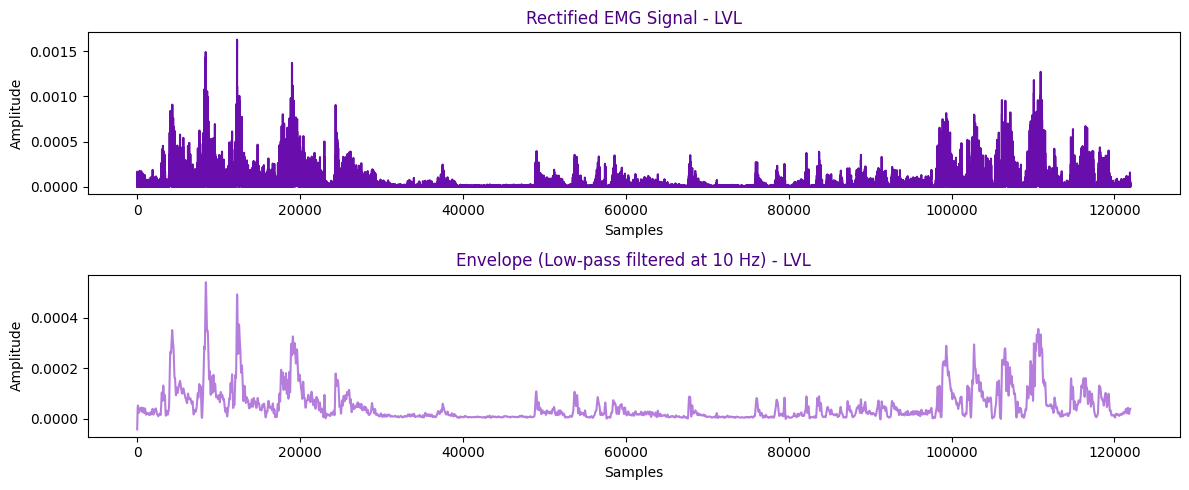

In [ ]:

# Define low-pass Butterworth filter
def lowpass_envelope(x, fs=2000, cutoff=10.0, order=4):
    nyq = 0.5 * fs
    wn = cutoff / nyq
    b, a = butter(order, wn, btype='low')
    return filtfilt(b, a, x)

# Select a participant and activity
p = list(rectified_data.keys())[0]
activity = list(rectified_data[p].keys())[0]
muscle = rectified_data[p][activity].columns[0]

# Get rectified signal
rectified_signal = rectified_data[p][activity][muscle].values

# Apply low-pass filter to get envelope
envelope_signal = lowpass_envelope(rectified_signal, fs=2000, cutoff=10)

# Plot comparison
plt.figure(figsize=(12, 5))

# Rectified signal (raw before smoothing)
plt.subplot(2, 1, 1)
plt.plot(rectified_signal, color='#6a0dad')  # dark purple
plt.title(f'Rectified EMG Signal - {muscle}', fontsize=12, color='#4b0082')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)

# Smoothed envelope after low-pass filter
plt.subplot(2, 1, 2)
plt.plot(envelope_signal, color='#b57edc')  # light purple
plt.title(f'Envelope (Low-pass filtered at 10 Hz) - {muscle}', fontsize=12, color='#4b0082')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)

plt.tight_layout()
plt.show()


##Normalization

This step normalizes the EMG envelope for each muscle channel so that all values are scaled between 0 and 1 within each participant and activity. This makes all muscles comparable regardless of differences in signal amplitude or electrode placement

In [ ]:
# Step 4 of Preprocessing: Normalization
# Normalize the signal so that all values are between 0 and 1 within each muscle channel

normalized_data = {}

for p, activities in envelope_data.items():
    normalized_data[p] = {}
    for activity, df in activities.items():
        norm_df = df.copy()
        for col in df.columns:
            # Use 95th percentile for normalization
            max_val = np.percentile(df[col].abs(), 95) + 1e-12  # Add a small value to avoid division by zero
            norm_df[col] = df[col] / max_val       # Divide by the 95th percentile
        normalized_data[p][activity] = norm_df
        print(f"Normalized signals (95th percentile) for {p} - {activity}: {list(df.columns)}")

print("\nNormalization (95th percentile) step successfully applied to all participants")

Normalized signals (95th percentile) for p1 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p1 - jump: ['LMGAS', 'RMGAS']
Normalized signals (95th percentile) for p10 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p10 - jump: ['LMGAS', 'RMGAS']
Normalized signals (95th percentile) for p11 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p11 - jump: ['LMGAS', 'RMGAS']
Normalized signals (95th percentile) for p12 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p12 - jump: ['LMGAS', 'RMGAS']
Normalized signals (95th percentile) for p2 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p2 - jump: ['LMGAS', 'RMGAS']
Normalized signals (95th percentile) for p3 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p3 - jump: ['LMGAS', 'RMGAS']
Normalized signals (95th percentile) for p4 - squat: ['LVL', 'RVL']
Normalized signals (95th percentile) for p4 - jump: ['LMGAS', 'RMGAS']
Normalized signals (9

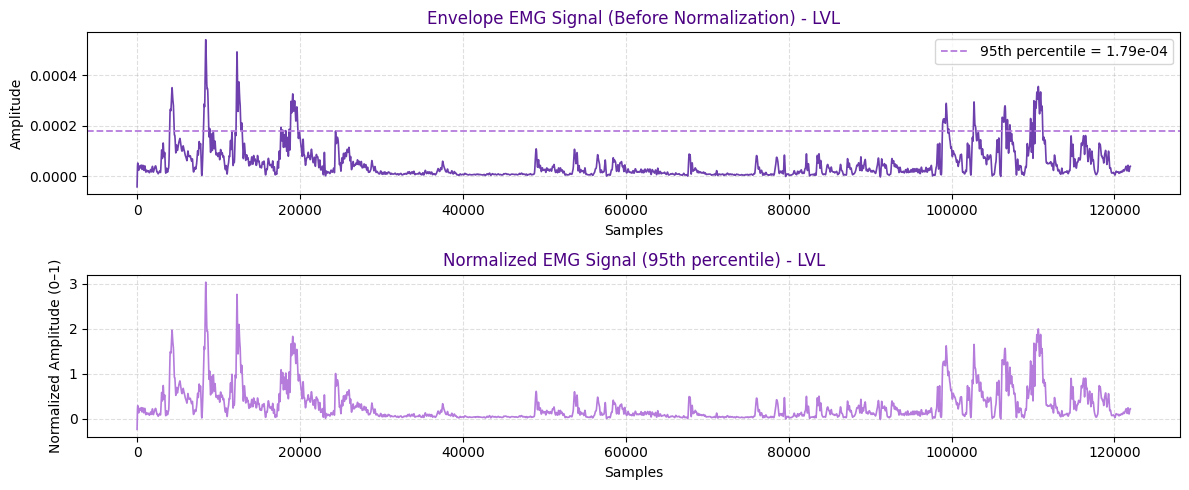

In [ ]:

# Select a participant and activity for visualization
p = list(envelope_data.keys())[0]
activity = list(envelope_data[p].keys())[0]
muscle = envelope_data[p][activity].columns[0]

# Get the signal before and after normalization
signal_before = envelope_data[p][activity][muscle].values
signal_after = normalized_data[p][activity][muscle].values

# Compute the 95th percentile value for visualization
p95 = np.percentile(np.abs(signal_before), 95)

# Plot comparison
plt.figure(figsize=(12, 5))

# Before normalization (envelope signal)
plt.subplot(2, 1, 1)
plt.plot(signal_before, color='#6d40ad', linewidth=1.2)
plt.axhline(p95, color='#b57cdc', linestyle='--', linewidth=1.3,
            label=f'95th percentile = {p95:.2e}')
plt.title(f'Envelope EMG Signal (Before Normalization) - {muscle}',
          fontsize=12, color='#4b0082')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# After normalization (0–1 scaled)
plt.subplot(2, 1, 2)
plt.plot(signal_after, color='#b57cdc', linewidth=1.2)
plt.title(f'Normalized EMG Signal (95th percentile) - {muscle}',
          fontsize=12, color='#4b0082')
plt.xlabel('Samples', fontsize=10)
plt.ylabel('Normalized Amplitude (0–1)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()



## Window Segmentation

This step segments the downsampled EMG signals into overlapping time windows (e.g., 0.5 s windows with 0.25 s overlap). Each window will later be used to compute RMS and Symmetry Index features

In [ ]:
# --- 2) Window Segmentation at 200 Hz ---

def segment_windows(df, fs, win_sec=0.5, hop_sec=0.25):
    """
    Splits each column in df into windows.
    Returns:
      X: dict {col -> ndarray [num_windows, win_len]}
      starts: array of window start indices (in samples)
    """
    win_len = int(round(win_sec * fs))
    hop_len = int(round(hop_sec * fs))
    n = len(df)
    starts = np.arange(0, n - win_len + 1, hop_len)

    X = {}
    for col in df.columns:
        sig = pd.to_numeric(df[col], errors='coerce').to_numpy()
        if len(starts):
            X[col] = np.vstack([sig[s:s+win_len] for s in starts])
        else:
            X[col] = np.empty((0, win_len))
    return X, starts

FS = 200           # Because the data was downsampled
WIN_SEC = 0.5      # Window length = 0.5 seconds (100 samples)
HOP_SEC = 0.25     # Hop size = 0.25 seconds (50 samples)

windows = {}  # windows[p][act] = {"X": {col: [num_windows, win_len]}, "starts": starts}

for p, acts in normalized_data.items():
    windows[p] = {}
    for act, df in acts.items():
        X, starts = segment_windows(df, fs=FS, win_sec=WIN_SEC, hop_sec=HOP_SEC)
        windows[p][act] = {"X": X, "starts": starts}
        print(f"Segmented {p}-{act}: {len(starts)} windows, win={int(WIN_SEC*FS)}, hop={int(HOP_SEC*FS)}")

print("\nWindow segmentation completed successfully.")


Segmented p1-squat: 2438 windows, win=100, hop=50
Segmented p1-jump: 2272 windows, win=100, hop=50
Segmented p10-squat: 1662 windows, win=100, hop=50
Segmented p10-jump: 2454 windows, win=100, hop=50
Segmented p11-squat: 1452 windows, win=100, hop=50
Segmented p11-jump: 2335 windows, win=100, hop=50
Segmented p12-squat: 2133 windows, win=100, hop=50
Segmented p12-jump: 2555 windows, win=100, hop=50
Segmented p2-squat: 1554 windows, win=100, hop=50
Segmented p2-jump: 567 windows, win=100, hop=50
Segmented p3-squat: 1513 windows, win=100, hop=50
Segmented p3-jump: 2737 windows, win=100, hop=50
Segmented p4-squat: 1058 windows, win=100, hop=50
Segmented p4-jump: 1820 windows, win=100, hop=50
Segmented p5-squat: 2901 windows, win=100, hop=50
Segmented p5-jump: 2279 windows, win=100, hop=50
Segmented p6-squat: 1899 windows, win=100, hop=50
Segmented p6-jump: 1725 windows, win=100, hop=50
Segmented p7-squat: 2105 windows, win=100, hop=50
Segmented p7-jump: 2177 windows, win=100, hop=50
Segme

#Feature Extraction

In this step, the processed and segmented EMG signals are used to extract numerical features that describe muscle activity and balance between the left and right sides.
For each participant and exercise, two main features are calculated from every window:

Root Mean Square (RMS):
Represents the average power or intensity of the EMG signal within a specific window. It provides a reliable indicator of muscle activation level.

Symmetry Index (SI):
Measures how balanced the activation is between the left and right muscles. Lower SI values indicate more symmetrical activity, while higher values suggest possible muscle imbalance.

All extracted features are collected into a structured DataFrame and saved as a CSV file for further statistical analysis or model training.

In [ ]:


# ============================================
#               Feature Functions
# ============================================

def compute_rms(x):
    return np.sqrt(np.mean(x**2))

def compute_mav(x):
    return np.mean(np.abs(x))

def compute_var(x):
    return np.var(x)

def compute_wl(x):
    return np.sum(np.abs(np.diff(x)))

def compute_zero_crossings(x):
    return ((x[:-1] * x[1:]) < 0).sum()

def compute_si(rms_left, rms_right):
    return abs(rms_right - rms_left) / 0.5 * (rms_right + rms_left + 1e-12)


# ============================================
#       Apply Feature Extraction on WINDOWS
# ============================================

all_features = []
for p, activities in windows.items():
    for act, content in activities.items():

        X = content["X"]   # dict of muscle windows

        # Identify Left + Right channels automatically
        left_key = None
        right_key = None

        for k in X.keys():
            if k.lower().startswith("l"):
                left_key = k
            if k.lower().startswith("r"):
                right_key = k

        if left_key is None or right_key is None:
            print("ERROR: Missing L/R channels in", p, act)
            continue

        L_win = X[left_key]
        R_win = X[right_key]

        num_windows = L_win.shape[0]

        for i in range(num_windows):

            L = L_win[i]
            R = R_win[i]

            # ============================
            #      Basic Features
            # ============================
            rms_l = compute_rms(L)
            rms_r = compute_rms(R)

            mav_l = compute_mav(L)
            mav_r = compute_mav(R)

            var_l = compute_var(L)
            var_r = compute_var(R)

            wl_l = compute_wl(L)
            wl_r = compute_wl(R)

            zc_l = compute_zero_crossings(L)
            zc_r = compute_zero_crossings(R)

            # ============================
            #       Combined Features
            # ============================
            diff = rms_l - rms_r
            absdiff = abs(diff)
            total = rms_l + rms_r
            ratio = rms_l / (rms_r + 1e-8)

            # ============================
            #       SI (your formula)
            # ============================
            si = compute_si(rms_l, rms_r)

            # ============================
            #        Store Features
            # ============================
            all_features.append({
                "Participant": p,
                "Activity": act,
                "Window": i,

                "RMS_L": rms_l,
                "RMS_R": rms_r,

                "MAV_L": mav_l,
                "MAV_R": mav_r,

                "VAR_L": var_l,
                "VAR_R": var_r,

                "WL_L": wl_l,
                "WL_R": wl_r,

                "ZC_L": zc_l,
                "ZC_R": zc_r,

                "Diff": diff,
                "AbsDiff": absdiff,
                "Total": total,
                "Ratio": ratio,

                "SI": si   # new SI formula
            })

# Convert to DataFrame
features_full_df = pd.DataFrame(all_features)
features_full_df.head()


,Participant,Activity,Window,RMS_L,RMS_R,MAV_L,MAV_R,VAR_L,VAR_R,WL_L,WL_R,ZC_L,ZC_R,Diff,AbsDiff,Total,Ratio,SI
0,p1,squat,0,0.208172,0.080962,0.187331,0.076044,0.026327,0.000772,0.533940,0.102421,1,0,0.127209,0.127209,0.289134,2.571216,0.073561
1,p1,squat,1,0.252117,0.088727,0.250080,0.088147,0.001023,0.000103,0.198484,0.036563,0,0,0.163390,0.163390,0.340844,2.841476,0.111381
2,p1,squat,2,0.198283,0.081070,0.191586,0.080700,0.002611,0.000060,0.153014,0.047840,0,0,0.117213,0.117213,0.279353,2.445816,0.065487
3,p1,squat,3,0.146341,0.108515,0.145580,0.105304,0.000222,0.000687,0.095599,0.080215,0,0,0.037826,0.037826,0.254856,1.348573,0.019280
4,p1,squat,4,0.175321,0.145657,0.172509,0.144363,0.000978,0.000375,0.092859,0.066642,0,0,0.029664,0.029664,0.320978,1.203656,0.019043


##Inactive Window Removal





After feature extraction, some windows contain almost no muscle activity (very low RMS values). These windows are not useful for the model, so we remove them to keep only the segments that show real muscle activation. This step improves data quality and ensures the dataset focuses on meaningful EMG activity.

In [ ]:
# =======================================================
#        Remove Inactive Windows After Extraction
# =======================================================

RMS_THRESHOLD = 0.05

active_df = features_full_df[
    (features_full_df["RMS_L"] > RMS_THRESHOLD) |
    (features_full_df["RMS_R"] > RMS_THRESHOLD)
]

print("Before removal:", len(features_full_df))
print("After removal:", len(active_df))
active_df.head()


Before removal: 47120
After removal: 37772


,Participant,Activity,Window,RMS_L,RMS_R,MAV_L,MAV_R,VAR_L,VAR_R,WL_L,WL_R,ZC_L,ZC_R,Diff,AbsDiff,Total,Ratio,SI
0,p1,squat,0,0.208172,0.080962,0.187331,0.076044,0.026327,0.000772,0.533940,0.102421,1,0,0.127209,0.127209,0.289134,2.571216,0.073561
1,p1,squat,1,0.252117,0.088727,0.250080,0.088147,0.001023,0.000103,0.198484,0.036563,0,0,0.163390,0.163390,0.340844,2.841476,0.111381
2,p1,squat,2,0.198283,0.081070,0.191586,0.080700,0.002611,0.000060,0.153014,0.047840,0,0,0.117213,0.117213,0.279353,2.445816,0.065487
3,p1,squat,3,0.146341,0.108515,0.145580,0.105304,0.000222,0.000687,0.095599,0.080215,0,0,0.037826,0.037826,0.254856,1.348573,0.019280
4,p1,squat,4,0.175321,0.145657,0.172509,0.144363,0.000978,0.000375,0.092859,0.066642,0,0,0.029664,0.029664,0.320978,1.203656,0.019043


In [ ]:
# =====================================================
#   Save only the features used in the model (without Label)
#   for a single participant + squat exercise only
# =====================================================

# 1) Identify the participant
target_participant = "p7"

# 2) Features to be input to the model
model_features = ["RMS_L", "RMS_R", "Diff", "AbsDiff", "Total", "Ratio"]

# 3) Filter data for a single participant + squat exercise only
single_participant_squat = active_df[
    (active_df["Participant"] == target_participant) &
    (active_df["Activity"] == "squat")
][model_features]

# 4) Display to verify
print(single_participant_squat.head())

# 5) Save to CSV
single_participant_squat.to_csv(
    f"{target_participant}_squat_features_only.csv",
    index=False
)

print(f"Saved successfully as {target_participant}_squat_features_only.csv")


          RMS_L     RMS_R      Diff   AbsDiff     Total      Ratio
35361  0.066682  0.021516  0.045166  0.045166  0.088197   3.099214
35362  0.096380  0.019654  0.076725  0.076725  0.116034   4.903759
35363  0.134792  0.017460  0.117332  0.117332  0.152252   7.719938
35364  0.186551  0.018740  0.167811  0.167811  0.205291   9.954917
35365  0.233626  0.020047  0.213579  0.213579  0.253673  11.653896
Saved successfully as p7_squat_features_only.csv


In this step, each 0.5-second EMG window is assigned a label (Balanced or Imbalance) based on the computed Symmetry Index (SI).
A threshold of 15% asymmetry (SI > 0.15) is used, which aligns with values commonly reported in biomechanics literature for identifying clinically meaningful neuromuscular imbalance.

What this code does:

Applies the SI threshold to every window

Converts numerical SI values into categorical labels

Adds a new Label column to the feature dataset

In [ ]:
THRESHOLD = 0.15

def assign_label(si):
    return "Imbalance" if si > THRESHOLD else "Balanced"

active_df["Label"] = active_df["SI"].apply(assign_label)

active_df.head()


/tmp/ipython-input-2275794806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_df["Label"] = active_df["SI"].apply(assign_label)


,Participant,Activity,Window,RMS_L,RMS_R,MAV_L,MAV_R,VAR_L,VAR_R,WL_L,WL_R,ZC_L,ZC_R,Diff,AbsDiff,Total,Ratio,SI,Label
0,p1,squat,0,0.208172,0.080962,0.187331,0.076044,0.026327,0.000772,0.533940,0.102421,1,0,0.127209,0.127209,0.289134,2.571216,0.073561,Balanced
1,p1,squat,1,0.252117,0.088727,0.250080,0.088147,0.001023,0.000103,0.198484,0.036563,0,0,0.163390,0.163390,0.340844,2.841476,0.111381,Balanced
2,p1,squat,2,0.198283,0.081070,0.191586,0.080700,0.002611,0.000060,0.153014,0.047840,0,0,0.117213,0.117213,0.279353,2.445816,0.065487,Balanced
3,p1,squat,3,0.146341,0.108515,0.145580,0.105304,0.000222,0.000687,0.095599,0.080215,0,0,0.037826,0.037826,0.254856,1.348573,0.019280,Balanced
4,p1,squat,4,0.175321,0.145657,0.172509,0.144363,0.000978,0.000375,0.092859,0.066642,0,0,0.029664,0.029664,0.320978,1.203656,0.019043,Balanced


This step saves all extracted features—including RMS, MAV, VAR, WL, ZC, Diff, AbsDiff, Total, Ratio, and the assigned label—into a CSV file.
The CSV file serves as a clean and structured dataset that can be used for training machine-learning models or external statistical analysis.

What this code does:

Converts the full feature table into .csv format

Ensures reproducibility and easy loading for later steps

Confirms the file was saved successfully

In [ ]:
# Save the extracted features to CSV
active_df.to_csv("features_extracted.csv", index=False)

print("CSV file saved successfully as features_extracted.csv")


CSV file saved successfully as features_extracted.csv


To identify the most informative EMG features for detecting muscle imbalance.
RFE (Recursive Feature Elimination) iteratively evaluates feature importance using a Random Forest model and removes the least important ones until only the top features remain.

Why Random Forest:
Random Forest is widely used for wrapper-based feature selection because it captures non-linear patterns and detects interactions between EMG features.

What this code does:

Loads all features except SI and Label

Runs RFE to select the top 5 most predictive features

Produces a ranking table showing which features were selected

In [ ]:

# Load features
df = active_df.copy()

# =============================
#     1) Remove SI
# =============================
X = df.drop(columns=["SI", "Label", "Participant", "Activity", "Window"])
y = df["Label"]

# =============================
#     2) Apply RFE
# =============================
model = RandomForestClassifier(n_estimators=200, random_state=42)

selector = RFE(estimator=model, n_features_to_select=5)
selector.fit(X, y)

# =============================
#     3) Show selected features
# =============================
selected_df = pd.DataFrame({
    "Feature": X.columns,
    "Selected": selector.support_,
    "Ranking": selector.ranking_
})

selected_df.sort_values("Ranking", inplace=True)
selected_df


,Feature,Selected,Ranking
0,RMS_L,True,1
1,RMS_R,True,1
10,Diff,True,1
11,AbsDiff,True,1
12,Total,True,1
3,MAV_R,False,2
2,MAV_L,False,3
13,Ratio,False,4
7,WL_R,False,5
6,WL_L,False,6


This step provides an overview of the dataset by counting how many windows are labeled as Balanced vs. Imbalance based on the Symmetry Index threshold.
This helps confirm that the dataset is correctly labeled and allows checking for class imbalance before model training.

In [ ]:
balanced_count = (active_df["Label"] == "Balanced").sum()
imbalance_count = (active_df["Label"] == "Imbalance").sum()

print("Balanced windows:", balanced_count)
print("Imbalance windows:", imbalance_count)


Balanced windows: 23697
Imbalance windows: 14075


This cell specifies the exact EMG features that will be used as inputs to the
machine-learning models.
The selected features are based on the RFE (wrapper method) results, ensuring we only keep the most informative predictors for muscle imbalance classification.

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = [
    "RMS_L", "RMS_R",
    "Diff", "AbsDiff", "Total", "Ratio"
]

# الليبل
y = active_df["Label"]

# Define X from the DataFrame using the feature_cols
X = active_df[feature_cols]

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 30217
Test size: 7555


#Machine Learning methods

##SVM

In this step, an SVM classifier with an RBF kernel is trained using the selected EMG features.
SVM is particularly effective for handling non-linear boundaries and is widely used in EMG pattern-recognition tasks due to its robustness against noise and ability to separate classes with a maximal margin.
After training the model, predictions are generated, and the performance is evaluated through accuracy, classification report, and a confusion matrix visualized using a purple-themed heatmap.

In [ ]:

# =====================================================
#                 1) SVM Classifier
# =====================================================
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)

print("===== SVM RESULTS =====")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_pred))
print("\nClassification Report:\n", classification_report(y_test, svm_pred))

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.show()

##Random Forest

This section trains a Random Forest model using 200 decision trees to capture non-linear interactions among EMG features.
Random Forest is highly effective for physiological data because it handles variance, learns feature interactions, and remains stable even with noisy biological signals.
The model’s predictions on the test set are evaluated using accuracy metrics, detailed classification statistics, and a visual confusion matrix rendered with purple gradients.

In [ ]:
# =====================================================
#           2) Random Forest Classifier
# =====================================================
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
final_model = rf_model
rf_pred = rf_model.predict(X_test)

print("===== RANDOM FOREST RESULTS =====")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Random Forest Confusion Matrix")
plt.show()

##Logistic Regression

Here, a Logistic Regression model is trained as a strong interpretable baseline classifier for the binary imbalance detection task.
This model assumes a linear relationship between the extracted EMG features and the target label, allowing us to assess how well linear patterns alone can differentiate balanced vs. imbalanced activation.
The classifier’s performance is summarized through accuracy, precision-recall-F1 metrics, and a confusion matrix visualized in purple tone.

In [ ]:
# =====================================================
#       3) Logistic Regression Classifier
# =====================================================
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)

log_pred = log_model.predict(X_test)

print("===== LOGISTIC REGRESSION RESULTS =====")
print("Accuracy:", accuracy_score(y_test, log_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, log_pred))
print("\nClassification Report:\n", classification_report(y_test, log_pred))

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Logistic Regression Confusion Matrix")
plt.show()
